# **SEL-NNML Analysis & Visualization - Dataset 1**

This notebook contains comprehensive analysis and visualizations organized as follows:

**Part 1: All Models Comparison**
- Performance metrics comparison (Accuracy, Precision, Recall, F1-Score)
- ROC curves for all models

**Part 2: HPO Methods Comparison for SEL-NNML**
- Optimization convergence plots across all HPO methods
- Computational cost analysis (training times)

**Part 3: SEL-NNML Detailed Analysis (TPE only)**
- Confusion Matrix
- Feature Importance
- Ablation Study

## Setup: Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import os
from scipy.signal import savgol_filter
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set visualization directory
viz_dir = '../artifacts/ds1/visualizations'
os.makedirs(viz_dir, exist_ok=True)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


---
# **PART 1: All Models Comparison**

Comparing all machine learning models (Logistic Regression, Decision Tree, Random Forest, KNN, SVM, AdaBoost, Gradient Boosting, SEL-NNML) across different optimization samplers.

## 1.1 Load All Models Performance Metrics

In [2]:
# Load metrics for all models across all samplers
metrics_path = '../artifacts/ds1/models/all_models_metrics.csv'
all_metrics_df = pd.read_csv(metrics_path)

# Load ROC data
roc_path = '../artifacts/ds1/models/all_models_roc_data.csv'
all_roc_df = pd.read_csv(roc_path)

print("✓ Loaded metrics for all models")
print(f"Total configurations: {len(all_metrics_df)}")
print(f"Samplers: {all_metrics_df['Sampler'].unique()}")
print(f"Models: {all_metrics_df['Model'].unique()}\n")

print("Dataset preview:")
display(all_metrics_df.head(10))

✓ Loaded metrics for all models
Total configurations: 41
Samplers: ['Baseline' 'TPE' 'GP' 'CMA-ES' 'QMC']
Models: ['Logistic Regression (Default)' 'Decision Tree (Default)'
 'Random Forest (Default)' 'K-Nearest Neighbors (Default)'
 'Support Vector Machine (Default)' 'AdaBoost (Default)'
 'Gradient Boosting (Default)' 'Stacking + Linear Regression'
 'Stacking + Default MLP' 'Logistic Regression' 'Decision Tree'
 'Random Forest' 'K-Nearest Neighbors' 'Support Vector Machine' 'AdaBoost'
 'Gradient Boosting' 'SEL-NNML']

Dataset preview:


,Sampler,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Baseline,Logistic Regression (Default),0.886667,0.918919,0.860759,0.888889,0.957746
1,Baseline,Decision Tree (Default),0.860000,0.902778,0.822785,0.860927,0.862097
2,Baseline,Random Forest (Default),0.880000,0.942029,0.822785,0.878378,0.951239
3,Baseline,K-Nearest Neighbors (Default),0.873333,0.905405,0.848101,0.875817,0.931093
4,Baseline,Support Vector Machine (Default),0.906667,0.922078,0.898734,0.910256,0.949011
5,Baseline,AdaBoost (Default),0.880000,0.929577,0.835443,0.880000,0.958281
6,Baseline,Gradient Boosting (Default),0.886667,0.930556,0.848101,0.887417,0.959708
7,Baseline,Stacking + Linear Regression,0.900000,0.921053,0.886076,0.903226,0.953468
8,Baseline,Stacking + Default MLP,0.900000,0.921053,0.886076,0.903226,0.952755
9,TPE,Logistic Regression,0.900000,0.921053,0.886076,0.903226,0.953111


## 1.2 All Models Performance Comparison - Table View

In [3]:
# Create summary table showing all 13 model configurations
# 9 baseline models + 4 optimized SEL-NNML models = 13 total

summary_metrics = []

# Get baseline models (9 models)
baseline_models = all_metrics_df[all_metrics_df['Sampler'] == 'Baseline'].copy()

for _, row in baseline_models.iterrows():
    summary_metrics.append({
        'Model Configuration': row['Model'],
        'Category': 'Baseline',
        'Accuracy': f"{row['Accuracy']:.4f}",
        'Precision': f"{row['Precision']:.4f}",
        'Recall': f"{row['Recall']:.4f}",
        'F1-Score': f"{row['F1-Score']:.4f}",
        'AUC': f"{row['AUC']:.4f}"
    })

# Get optimized SEL-NNML models (4 models)
sel_nnml_models = all_metrics_df[
    (all_metrics_df['Model'] == 'SEL-NNML') & 
    (all_metrics_df['Sampler'] != 'Baseline')
].copy()

for _, row in sel_nnml_models.iterrows():
    summary_metrics.append({
        'Model Configuration': f"SEL-NNML ({row['Sampler']})",
        'Category': 'Optimized',
        'Accuracy': f"{row['Accuracy']:.4f}",
        'Precision': f"{row['Precision']:.4f}",
        'Recall': f"{row['Recall']:.4f}",
        'F1-Score': f"{row['F1-Score']:.4f}",
        'AUC': f"{row['AUC']:.4f}"
    })

summary_df = pd.DataFrame(summary_metrics)

# Sort by accuracy (descending)
summary_df['Accuracy_val'] = summary_df['Accuracy'].astype(float)
summary_df = summary_df.sort_values('Accuracy_val', ascending=False).drop('Accuracy_val', axis=1)

print("\n" + "="*110)
print("ALL 13 MODEL CONFIGURATIONS PERFORMANCE COMPARISON")
print("="*110)
print(f"Total Models: {len(summary_df)}")
print(f"  - Baseline: {len(summary_df[summary_df['Category'] == 'Baseline'])}")
print(f"  - Optimized: {len(summary_df[summary_df['Category'] == 'Optimized'])}")
print("="*110)
display(summary_df)
print("="*110)


ALL 13 MODEL CONFIGURATIONS PERFORMANCE COMPARISON
Total Models: 13
  - Baseline: 9
  - Optimized: 4


,Model Configuration,Category,Accuracy,Precision,Recall,F1-Score,AUC
9,SEL-NNML (TPE),Optimized,0.9400,0.9487,0.9367,0.9427,0.9631
11,SEL-NNML (CMA-ES),Optimized,0.9267,0.9474,0.9114,0.9290,0.9613
10,SEL-NNML (GP),Optimized,0.9200,0.9351,0.9114,0.9231,0.9613
12,SEL-NNML (QMC),Optimized,0.9200,0.8851,0.9747,0.9277,0.9617
4,Support Vector Machine (Default),Baseline,0.9067,0.9221,0.8987,0.9103,0.9490
7,Stacking + Linear Regression,Baseline,0.9000,0.9211,0.8861,0.9032,0.9535
8,Stacking + Default MLP,Baseline,0.9000,0.9211,0.8861,0.9032,0.9528
0,Logistic Regression (Default),Baseline,0.8867,0.9189,0.8608,0.8889,0.9577
6,Gradient Boosting (Default),Baseline,0.8867,0.9306,0.8481,0.8874,0.9597
2,Random Forest (Default),Baseline,0.8800,0.9420,0.8228,0.8784,0.9512


## 1.3 All Models Performance Comparison - Visualization

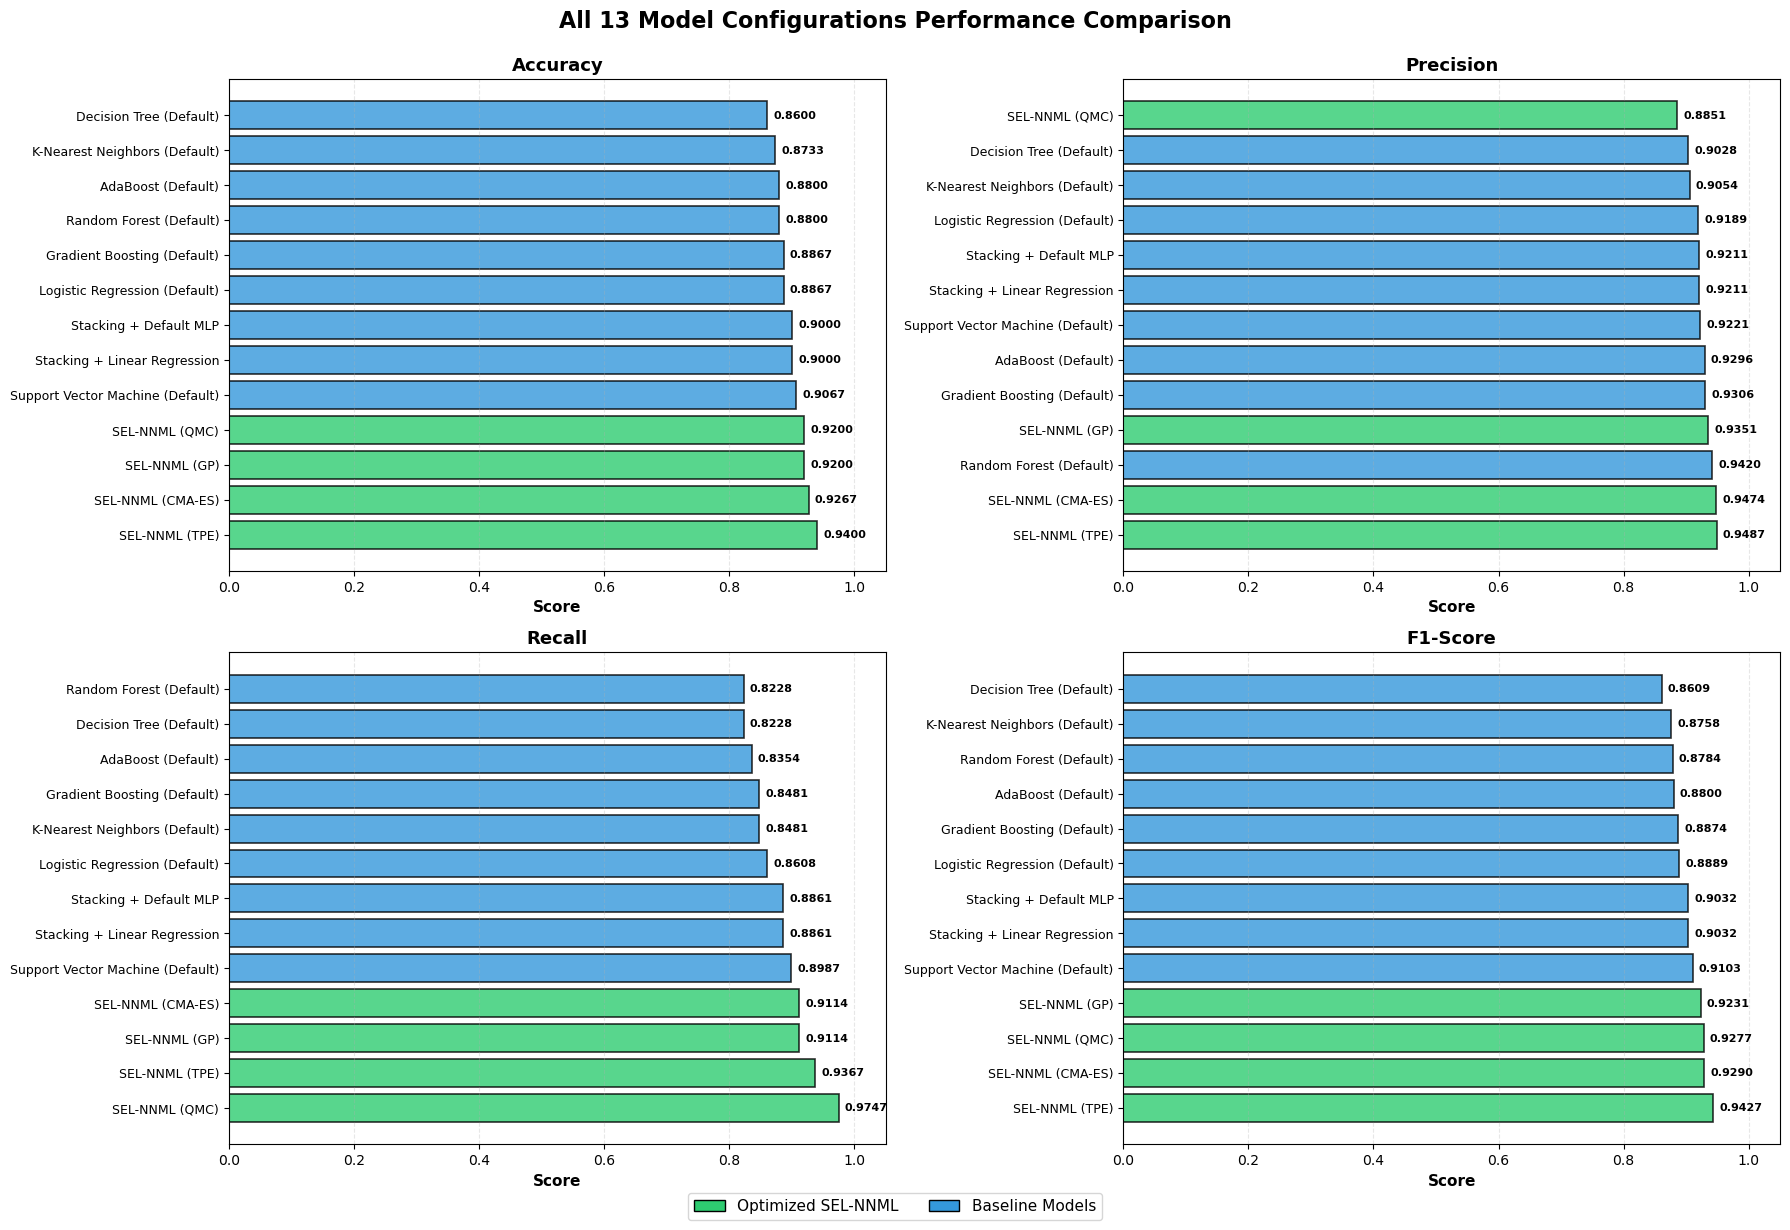

In [4]:
# Create bar chart comparison for all 13 models
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('All 13 Model Configurations Performance Comparison', 
             fontsize=16, fontweight='bold', y=0.995)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Prepare data for all 13 models (same logic as section 1.2)
all_13_models = []

# Add baseline models (9 models)
baseline_data = all_metrics_df[all_metrics_df['Sampler'] == 'Baseline'].copy()
for _, row in baseline_data.iterrows():
    all_13_models.append({
        'Model': row['Model'],
        'Accuracy': row['Accuracy'],
        'Precision': row['Precision'],
        'Recall': row['Recall'],
        'F1-Score': row['F1-Score'],
        'Category': 'Baseline'
    })

# Add optimized SEL-NNML models (4 models)
sel_nnml_data = all_metrics_df[
    (all_metrics_df['Model'] == 'SEL-NNML') & 
    (all_metrics_df['Sampler'] != 'Baseline')
].copy()
for _, row in sel_nnml_data.iterrows():
    all_13_models.append({
        'Model': f"SEL-NNML ({row['Sampler']})",
        'Accuracy': row['Accuracy'],
        'Precision': row['Precision'],
        'Recall': row['Recall'],
        'F1-Score': row['F1-Score'],
        'Category': 'Optimized'
    })

models_df = pd.DataFrame(all_13_models)

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Sort by metric value
    sorted_df = models_df.sort_values(by=metric, ascending=False)
    
    # Color code by category
    colors = ['#2ecc71' if cat == 'Optimized' else '#3498db' for cat in sorted_df['Category']]
    
    bars = ax.barh(range(len(sorted_df)), sorted_df[metric].values, color=colors, 
                   edgecolor='black', linewidth=1.2, alpha=0.8)
    
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['Model'].values, fontsize=9)
    ax.set_xlabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(metric, fontsize=13, fontweight='bold')
    ax.set_xlim([0, 1.05])
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, v in enumerate(sorted_df[metric].values):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=8, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', edgecolor='black', label='Optimized SEL-NNML'),
    Patch(facecolor='#3498db', edgecolor='black', label='Baseline Models')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, 
           bbox_to_anchor=(0.5, -0.02), fontsize=11, frameon=True)

plt.tight_layout()
plt.show()

## 1.5 ROC Curves - All 13 Models

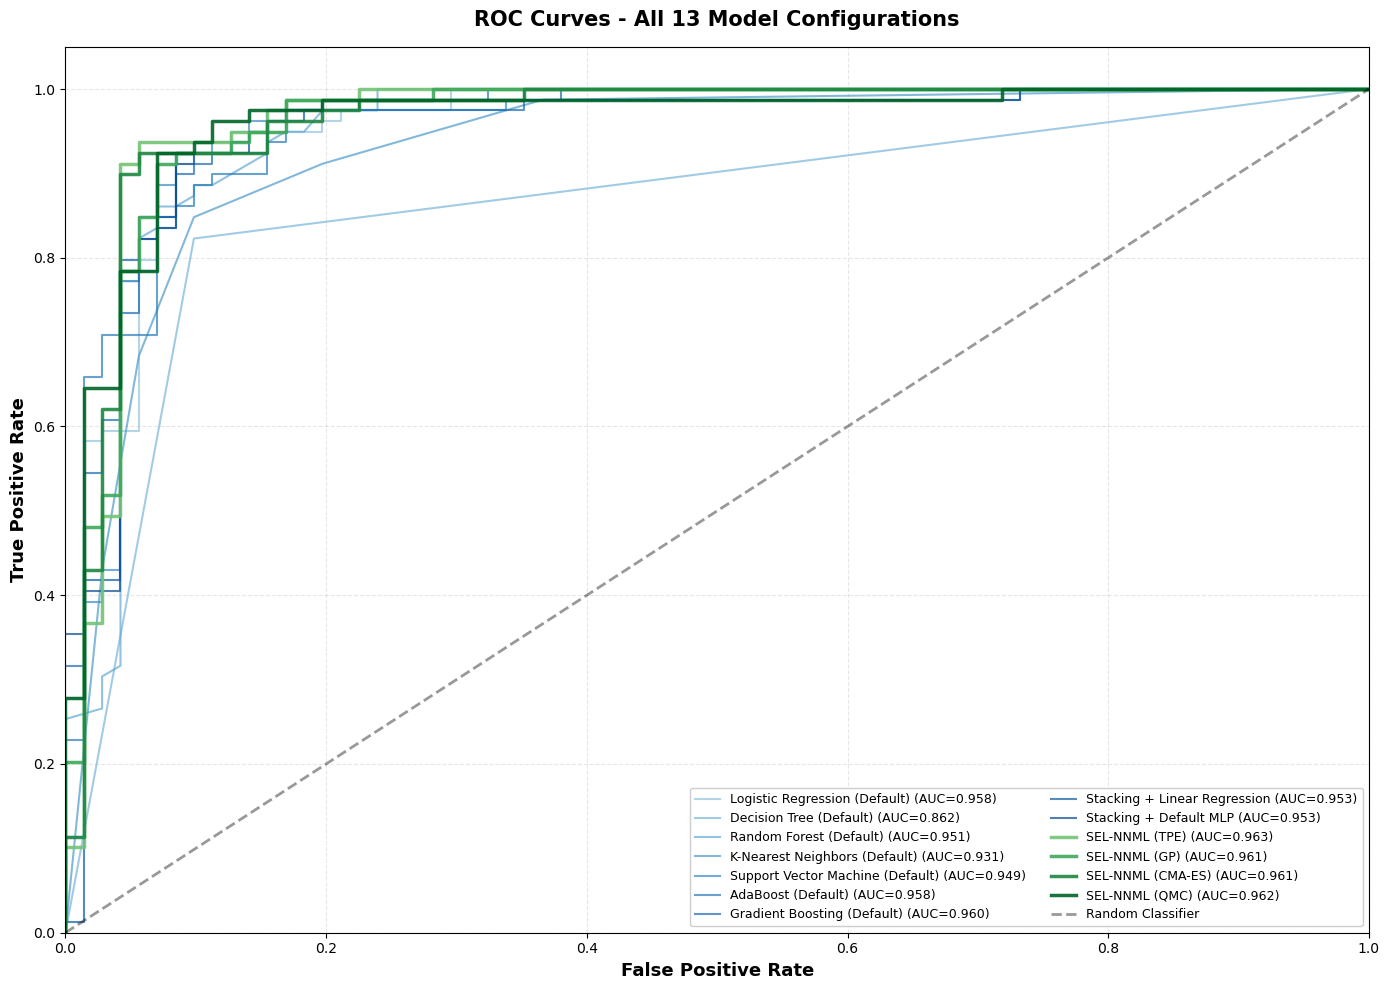

In [5]:
# ROC curves for all 13 model configurations on a single chart
fig, ax = plt.subplots(figsize=(14, 10))

# Prepare data for all 13 models (same logic as sections 1.2 and 1.3)
all_13_roc = []

# Add baseline models (9 models)
baseline_data = all_metrics_df[all_metrics_df['Sampler'] == 'Baseline'].copy()
baseline_roc = all_roc_df[all_roc_df['Sampler'] == 'Baseline'].copy()

for _, row in baseline_data.iterrows():
    model_name = row['Model']
    auc_value = row['AUC']
    model_roc_data = baseline_roc[baseline_roc['Model'] == model_name]
    
    all_13_roc.append({
        'name': model_name,
        'auc': auc_value,
        'fpr': model_roc_data['FPR'].values,
        'tpr': model_roc_data['TPR'].values,
        'category': 'Baseline'
    })

# Add optimized SEL-NNML models (4 models)
sel_nnml_data = all_metrics_df[
    (all_metrics_df['Model'] == 'SEL-NNML') & 
    (all_metrics_df['Sampler'] != 'Baseline')
].copy()
sel_nnml_roc = all_roc_df[
    (all_roc_df['Model'] == 'SEL-NNML') & 
    (all_roc_df['Sampler'] != 'Baseline')
].copy()

for _, row in sel_nnml_data.iterrows():
    sampler = row['Sampler']
    auc_value = row['AUC']
    model_roc_data = sel_nnml_roc[sel_nnml_roc['Sampler'] == sampler]
    
    all_13_roc.append({
        'name': f"SEL-NNML ({sampler})",
        'auc': auc_value,
        'fpr': model_roc_data['FPR'].values,
        'tpr': model_roc_data['TPR'].values,
        'category': 'Optimized'
    })

# Color palette: Blues for baseline, Greens for optimized
baseline_colors = cm.Blues(np.linspace(0.4, 0.9, 9))
optimized_colors = cm.Greens(np.linspace(0.5, 0.9, 4))

# Plot all 13 ROC curves
for idx, model_data in enumerate(all_13_roc):
    if model_data['category'] == 'Baseline':
        color = baseline_colors[idx]
        linewidth = 1.5
        alpha = 0.7
    else:
        color = optimized_colors[idx - 9]  # Offset for optimized models
        linewidth = 2.5
        alpha = 0.9
    
    ax.plot(model_data['fpr'], model_data['tpr'],
            color=color, linewidth=linewidth, alpha=alpha,
            label=f"{model_data['name']} (AUC={model_data['auc']:.3f})")

# Plot diagonal reference line
ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.4, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves - All 13 Model Configurations', fontsize=15, fontweight='bold', pad=15)
ax.legend(loc="lower right", fontsize=9, framealpha=0.95, ncol=2)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## 1.6 Save Part 1 Visualizations

In [6]:
# Save performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('All Models Performance Comparison (Best Sampler for Each Model)', 
             fontsize=16, fontweight='bold', y=0.995)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    best_per_model = all_metrics_df.groupby('Model')[metric].max().sort_values(ascending=False)
    colors_map = {
        'SEL-NNML': '#e74c3c', 'Gradient Boosting': '#3498db', 'Random Forest': '#2ecc71',
        'AdaBoost': '#f39c12', 'Support Vector Machine': '#9b59b6', 
        'Logistic Regression': '#1abc9c', 'K-Nearest Neighbors': '#e67e22', 'Decision Tree': '#95a5a6'
    }
    bar_colors = [colors_map.get(model, '#95a5a6') for model in best_per_model.index]
    bars = ax.barh(range(len(best_per_model)), best_per_model.values, color=bar_colors, 
                   edgecolor='black', linewidth=1.2, alpha=0.8)
    ax.set_yticks(range(len(best_per_model)))
    ax.set_yticklabels(best_per_model.index, fontsize=10)
    ax.set_xlabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(metric, fontsize=13, fontweight='bold')
    ax.set_xlim([0, 1.05])
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    for i, v in enumerate(best_per_model.values):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9, fontweight='bold')
plt.tight_layout()
perf_path = os.path.join(viz_dir, 'part1_all_models_performance_comparison.png')
plt.savefig(perf_path, dpi=300, bbox_inches='tight')
print(f'✓ Performance comparison saved to: {perf_path}')
plt.close()

# Save ROC curves for all 13 models
fig, ax = plt.subplots(figsize=(14, 10))

# Prepare data for all 13 models (same as section 1.5)
all_13_roc_save = []

# Add baseline models (9 models)
baseline_data_save = all_metrics_df[all_metrics_df['Sampler'] == 'Baseline'].copy()
baseline_roc_save = all_roc_df[all_roc_df['Sampler'] == 'Baseline'].copy()

for _, row in baseline_data_save.iterrows():
    model_name = row['Model']
    auc_value = row['AUC']
    model_roc_data = baseline_roc_save[baseline_roc_save['Model'] == model_name]
    
    all_13_roc_save.append({
        'name': model_name,
        'auc': auc_value,
        'fpr': model_roc_data['FPR'].values,
        'tpr': model_roc_data['TPR'].values,
        'category': 'Baseline'
    })

# Add optimized SEL-NNML models (4 models)
sel_nnml_data_save = all_metrics_df[
    (all_metrics_df['Model'] == 'SEL-NNML') & 
    (all_metrics_df['Sampler'] != 'Baseline')
].copy()
sel_nnml_roc_save = all_roc_df[
    (all_roc_df['Model'] == 'SEL-NNML') & 
    (all_roc_df['Sampler'] != 'Baseline')
].copy()

for _, row in sel_nnml_data_save.iterrows():
    sampler = row['Sampler']
    auc_value = row['AUC']
    model_roc_data = sel_nnml_roc_save[sel_nnml_roc_save['Sampler'] == sampler]
    
    all_13_roc_save.append({
        'name': f"SEL-NNML ({sampler})",
        'auc': auc_value,
        'fpr': model_roc_data['FPR'].values,
        'tpr': model_roc_data['TPR'].values,
        'category': 'Optimized'
    })

# Color palette: Blues for baseline, Greens for optimized
baseline_colors_save = cm.Blues(np.linspace(0.4, 0.9, 9))
optimized_colors_save = cm.Greens(np.linspace(0.5, 0.9, 4))

# Plot all 13 ROC curves
for idx, model_data in enumerate(all_13_roc_save):
    if model_data['category'] == 'Baseline':
        color = baseline_colors_save[idx]
        linewidth = 1.5
        alpha = 0.7
    else:
        color = optimized_colors_save[idx - 9]
        linewidth = 2.5
        alpha = 0.9
    
    ax.plot(model_data['fpr'], model_data['tpr'],
            color=color, linewidth=linewidth, alpha=alpha,
            label=f"{model_data['name']} (AUC={model_data['auc']:.3f})")

# Plot diagonal reference line
ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.4, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves - All 13 Model Configurations', fontsize=15, fontweight='bold', pad=15)
ax.legend(loc="lower right", fontsize=9, framealpha=0.95, ncol=2)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
roc_path = os.path.join(viz_dir, 'part1_all_13_models_roc_curves.png')
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
print(f'✓ ROC curves (13 models) saved to: {roc_path}')
plt.close()

print(f'\n✅ Part 1 visualizations saved to {viz_dir}')

✓ Performance comparison saved to: ../artifacts/ds1/visualizations\part1_all_models_performance_comparison.png
✓ ROC curves (13 models) saved to: ../artifacts/ds1/visualizations\part1_all_13_models_roc_curves.png

✅ Part 1 visualizations saved to ../artifacts/ds1/visualizations


---
# **PART 2: HPO Methods Comparison for SEL-NNML**

Comparing different Hyperparameter Optimization methods (TPE, GP, CMA-ES, QMC) specifically for the SEL-NNML model.

## 2.1 Load Training Histories and Times

In [7]:
# Load training histories for all HPO methods
base_path = '../artifacts/ds1/models'
files = {
    'TPE': os.path.join(base_path, 'tpe', 'sel-nnml_training_history.csv'),
    'GP': os.path.join(base_path, 'gp', 'sel-nnml_training_history.csv'),
    'CMA-ES': os.path.join(base_path, 'cmaes', 'sel-nnml_training_history.csv'),
    'QMC': os.path.join(base_path, 'qmc', 'sel-nnml_training_history.csv')
}

for k, p in files.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Training history file not found: {p}")

tpe_history = pd.read_csv(files['TPE'])
gp_history = pd.read_csv(files['GP'])
cmaes_history = pd.read_csv(files['CMA-ES'])
qmc_history = pd.read_csv(files['QMC'])

samplers = [
    ('TPE', tpe_history, '#1f77b4', '-'),
    ('GP', gp_history, '#ff7f0e', '--'),
    ('CMA-ES', cmaes_history, '#2ca02c', '-.'),
    ('QMC', qmc_history, '#d62728', ':')
]

print('✓ Training histories loaded successfully!')
print(f"TPE: {tpe_history.shape}, GP: {gp_history.shape}, CMA-ES: {cmaes_history.shape}, QMC: {qmc_history.shape}")

# Load training times
times_path = '../artifacts/ds1/models/training_times.csv'
times_df = pd.read_csv(times_path)
print('\n✓ Training times loaded successfully!')

✓ Training histories loaded successfully!
TPE: (100, 2), GP: (100, 2), CMA-ES: (100, 2), QMC: (100, 2)

✓ Training times loaded successfully!


## 2.2 SEL-NNML Performance Comparison Across HPO Methods - Table

In [8]:
# Create comparison table for SEL-NNML across all HPO methods
sel_nnml_metrics = all_metrics_df[all_metrics_df['Model'] == 'SEL-NNML'].copy()
sel_nnml_metrics = sel_nnml_metrics.sort_values('Accuracy', ascending=False)

print("\n" + "="*100)
print("SEL-NNML PERFORMANCE ACROSS ALL HPO METHODS")
print("="*100)
display(sel_nnml_metrics[['Sampler', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']])
print("="*100)


SEL-NNML PERFORMANCE ACROSS ALL HPO METHODS


,Sampler,Accuracy,Precision,Recall,F1-Score,AUC
16,TPE,0.940000,0.948718,0.936709,0.942675,0.963095
32,CMA-ES,0.926667,0.947368,0.911392,0.929032,0.961312
24,GP,0.920000,0.935065,0.911392,0.923077,0.961312
40,QMC,0.920000,0.885057,0.974684,0.927711,0.961669


## 2.3 SEL-NNML Performance Comparison Across HPO Methods - Visualization

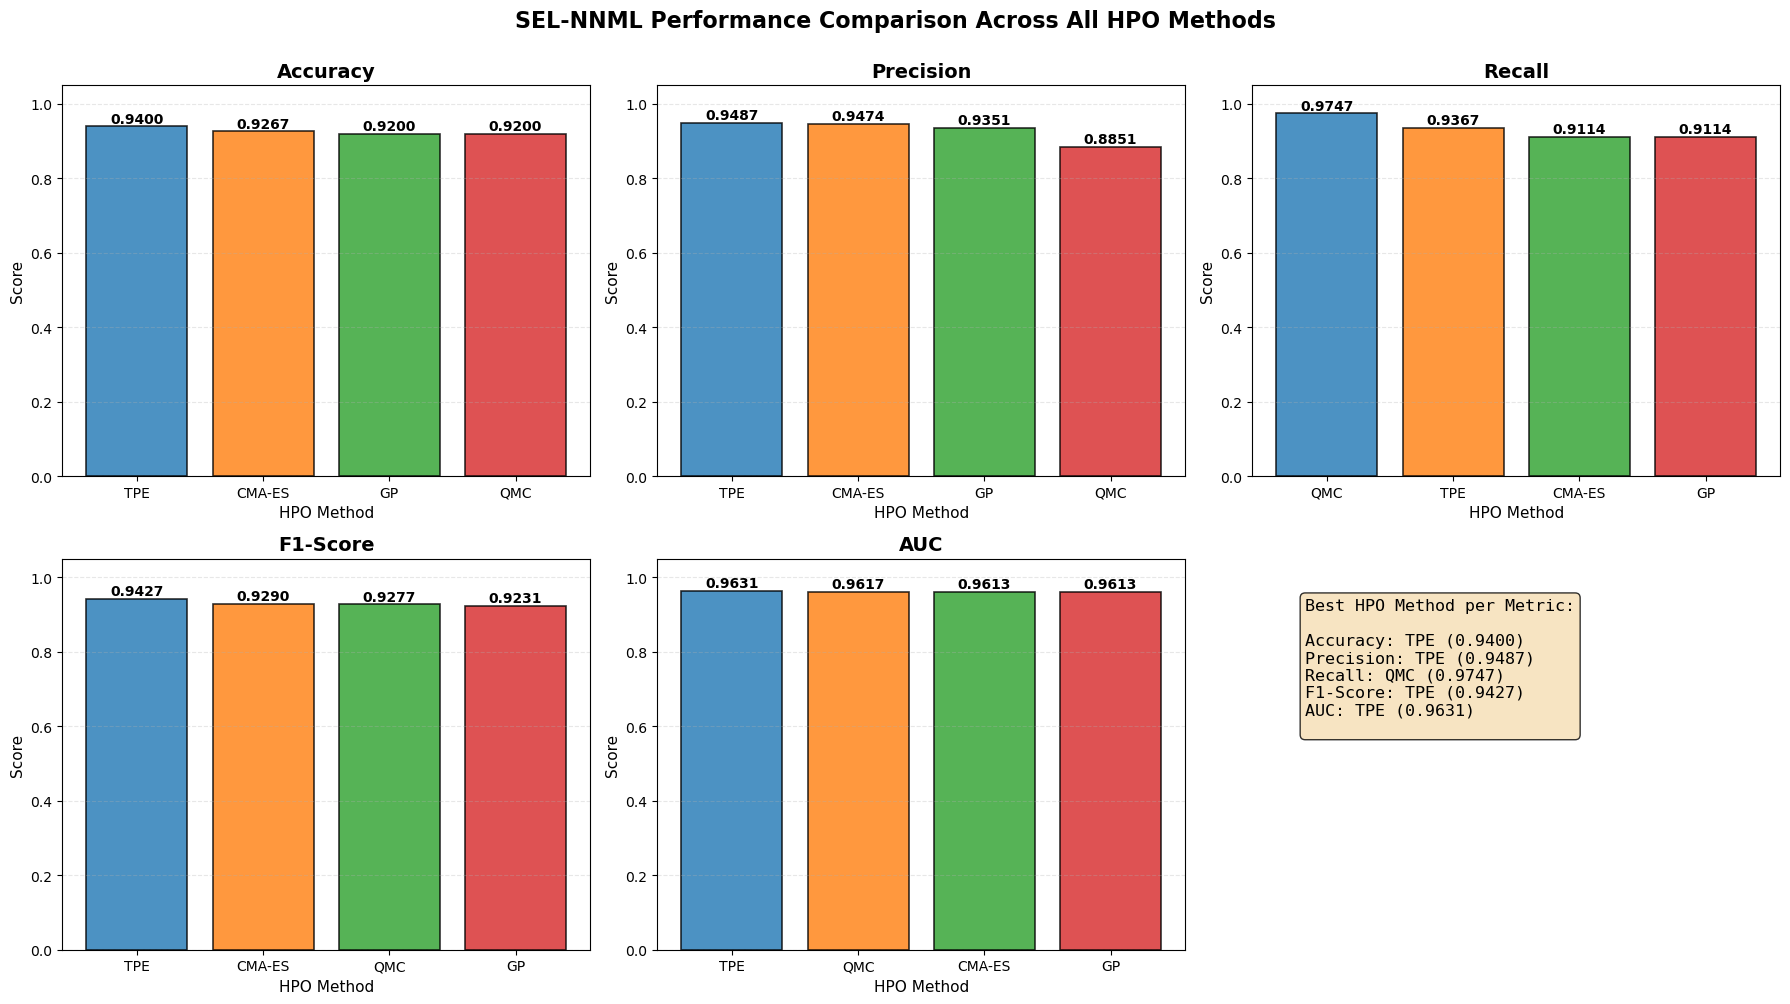

In [9]:
# Bar chart comparison for SEL-NNML across all HPO methods
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('SEL-NNML Performance Comparison Across All HPO Methods', 
             fontsize=16, fontweight='bold', y=1.00)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
hpo_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    sorted_df = sel_nnml_metrics.sort_values(by=metric, ascending=False)
    bars = ax.bar(sorted_df['Sampler'], sorted_df[metric], color=hpo_colors, 
                  edgecolor='black', linewidth=1.2, alpha=0.8)
    
    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    ax.set_xlabel('HPO Method', fontsize=11)
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, v in enumerate(sorted_df[metric]):
        ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

# Summary table in the last subplot
axes[1, 2].axis('off')
summary_text = "Best HPO Method per Metric:\n\n"
for metric in metrics_to_plot:
    best_hpo = sel_nnml_metrics.loc[sel_nnml_metrics[metric].idxmax(), 'Sampler']
    best_value = sel_nnml_metrics[metric].max()
    summary_text += f"{metric}: {best_hpo} ({best_value:.4f})\n"

axes[1, 2].text(0.1, 0.9, summary_text, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                family='monospace')

plt.tight_layout()
plt.show()

## 2.4 Optimization Convergence Plots - All HPO Methods

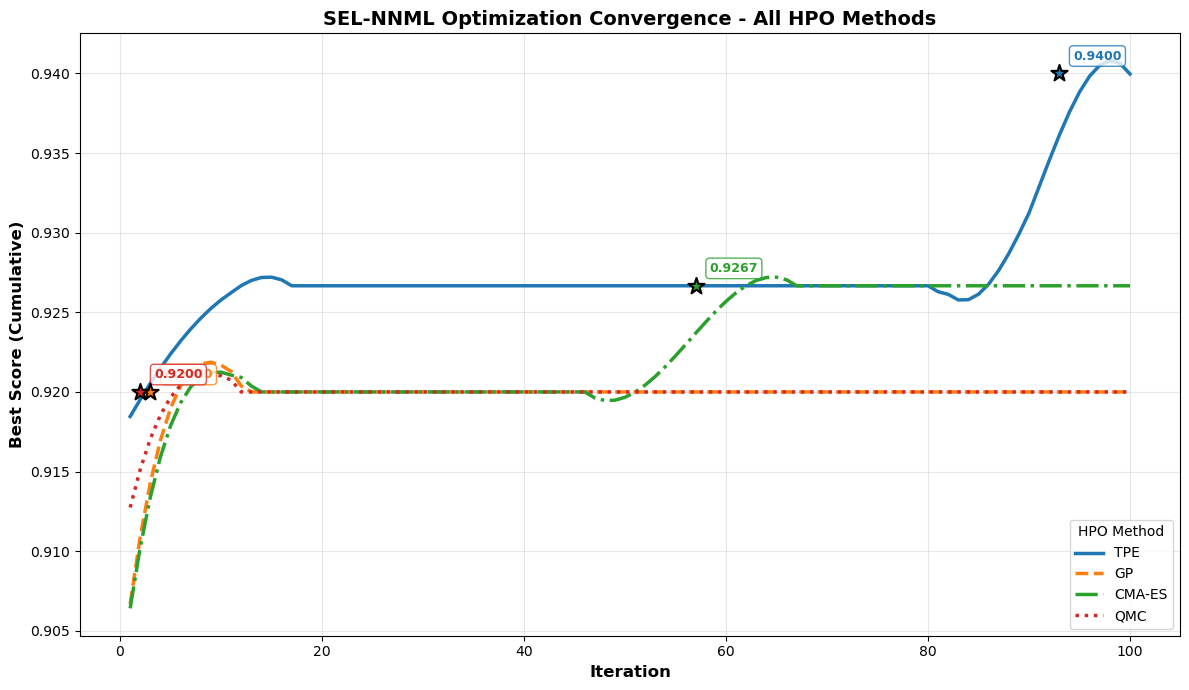

In [10]:
# Convergence chart showing cumulative best score over iterations
plt.figure(figsize=(12, 7))

for name, df, color, linestyle in samplers:
    cumulative_best = df['score'].cummax()
    x = df['iteration'].values
    y = cumulative_best.values
    
    # Apply Savitzky-Golay smoothing
    window_length = min(21, len(y) if len(y) % 2 == 1 else len(y) - 1)
    y_smooth = savgol_filter(y, window_length, 3)
    
    plt.plot(x, y_smooth, label=name, color=color, linewidth=2.5, linestyle=linestyle)
    
    # Highlight peak score
    peak_score = y.max()
    peak_iteration = x[y.argmax()]
    plt.scatter(peak_iteration, peak_score, color=color, s=150, marker='*', 
                edgecolors='black', linewidths=1.5, zorder=5)
    plt.annotate(f'{peak_score:.4f}', 
                xy=(peak_iteration, peak_score),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.8))

plt.xlabel('Iteration', fontsize=12, fontweight='bold')
plt.ylabel('Best Score (Cumulative)', fontsize=12, fontweight='bold')
plt.title('SEL-NNML Optimization Convergence - All HPO Methods', fontsize=14, fontweight='bold')
plt.legend(title='HPO Method', fontsize=10, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 2.5 Computational Cost Analysis - Table View

In [11]:
def seconds_to_hours(seconds):
    hours = seconds / 3600
    if hours < 0.01:
        minutes = seconds / 60
        return f"{minutes:.2f} min"
    return f"{hours:.4f} hrs"

# Create detailed timing table
table_data = []
for _, row in times_df.iterrows():
    table_data.append({
        'HPO Method': row['Sampler'],
        'Base Learner Time': seconds_to_hours(row['Base Models Training Time (seconds)']),
        'Meta Learner Time': seconds_to_hours(row['Meta Model Training Time (seconds)']),
        'Total Time': seconds_to_hours(row['Total Training Time (seconds)']),
        'Base (seconds)': f"{row['Base Models Training Time (seconds)']:.2f}",
        'Meta (seconds)': f"{row['Meta Model Training Time (seconds)']:.2f}",
        'Total (seconds)': f"{row['Total Training Time (seconds)']:.2f}"
    })

timing_table = pd.DataFrame(table_data)

print("\n" + "="*120)
print("COMPUTATIONAL COST ANALYSIS - SEL-NNML TRAINING TIME COMPARISON")
print("="*120)
display(timing_table)
print("="*120)


COMPUTATIONAL COST ANALYSIS - SEL-NNML TRAINING TIME COMPARISON


,HPO Method,Base Learner Time,Meta Learner Time,Total Time,Base (seconds),Meta (seconds),Total (seconds)
0,TPE,0.0149 hrs,0.0538 hrs,0.0688 hrs,53.73,193.78,247.52
1,GP,0.0507 hrs,0.0335 hrs,0.0842 hrs,182.45,120.71,303.15
2,CMA-ES,0.0146 hrs,0.0322 hrs,0.0468 hrs,52.42,115.98,168.40
3,QMC,0.0134 hrs,0.0260 hrs,0.0394 hrs,48.40,93.47,141.86


## 2.6 Computational Cost Analysis - Visualization

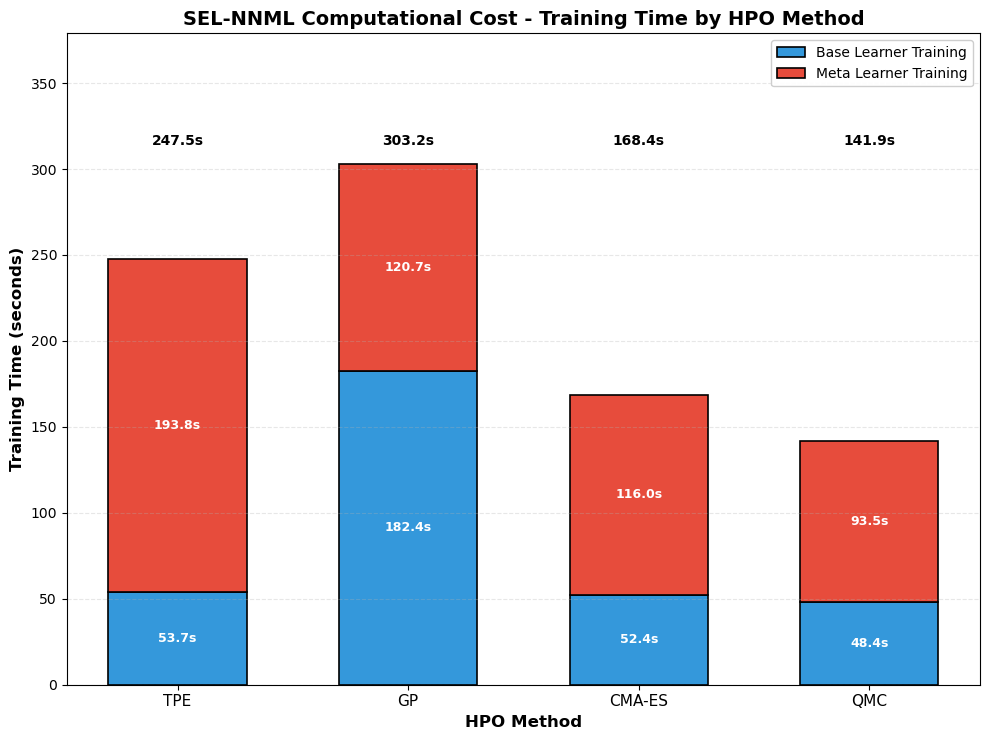

In [12]:
# Stacked bar chart showing training time breakdown
fig, ax = plt.subplots(figsize=(10, 7.5))

samplers_list = times_df['Sampler'].values
base_times = times_df['Base Models Training Time (seconds)'].values
meta_times = times_df['Meta Model Training Time (seconds)'].values

x = np.arange(len(samplers_list))
width = 0.6

bars1 = ax.bar(x, base_times, width, label='Base Learner Training', 
               color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x, meta_times, width, bottom=base_times, 
               label='Meta Learner Training', color='#e74c3c', edgecolor='black', linewidth=1.2)

max_total = (base_times + meta_times).max()
label_offset = max_total * 0.03

for i, (b, m) in enumerate(zip(base_times, meta_times)):
    total = b + m
    ax.text(i, b/2, f'{b:.1f}s', ha='center', va='center', 
            fontweight='bold', fontsize=9, color='white')
    ax.text(i, b + m/2, f'{m:.1f}s', ha='center', va='center', 
            fontweight='bold', fontsize=9, color='white')
    ax.text(i, max_total + label_offset, f'{total:.1f}s', ha='center', 
            va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('HPO Method', fontsize=12, fontweight='bold')
ax.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('SEL-NNML Computational Cost - Training Time by HPO Method', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(samplers_list, fontsize=11)
ax.legend(fontsize=10, loc='upper right', framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max_total * 1.25)

plt.tight_layout()
plt.show()

## 2.7 SEL-NNML ROC Curves - All HPO Methods

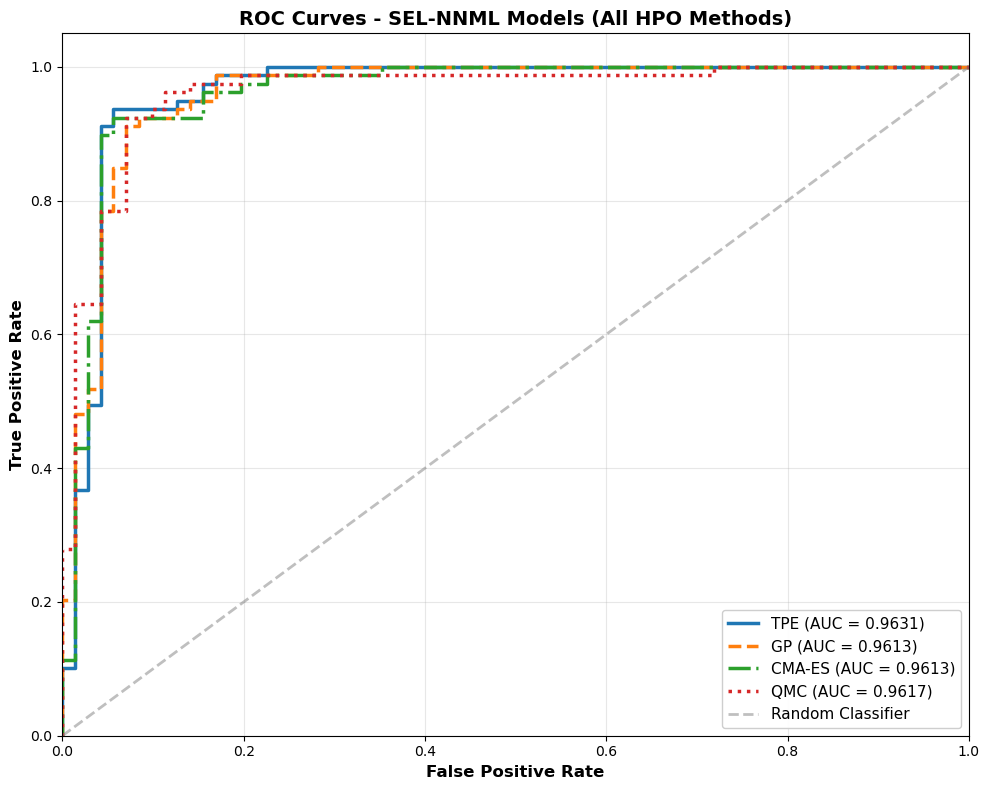

In [13]:
# ROC curves comparing SEL-NNML across all HPO methods
sel_nnml_roc = all_roc_df[all_roc_df['Model'] == 'SEL-NNML']

fig, ax = plt.subplots(figsize=(10, 8))

sampler_colors = {'TPE': '#1f77b4', 'GP': '#ff7f0e', 'CMA-ES': '#2ca02c', 'QMC': '#d62728'}
sampler_styles = {'TPE': '-', 'GP': '--', 'CMA-ES': '-.', 'QMC': ':'}

for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    sampler_data = sel_nnml_roc[sel_nnml_roc['Sampler'] == sampler]
    auc_value = sel_nnml_metrics[sel_nnml_metrics['Sampler'] == sampler]['AUC'].values[0]
    
    ax.plot(sampler_data['FPR'], sampler_data['TPR'], 
            color=sampler_colors[sampler], linestyle=sampler_styles[sampler],
            linewidth=2.5, label=f'{sampler} (AUC = {auc_value:.4f})')

# Plot diagonal line
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.5, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - SEL-NNML Models (All HPO Methods)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11, framealpha=0.95)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2.8 Save Part 2 Visualizations

In [14]:
# Save SEL-NNML performance comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('SEL-NNML Performance Comparison Across All HPO Methods', 
             fontsize=16, fontweight='bold', y=1.00)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
hpo_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    sorted_df = sel_nnml_metrics.sort_values(by=metric, ascending=False)
    bars = ax.bar(sorted_df['Sampler'], sorted_df[metric], color=hpo_colors, 
                  edgecolor='black', linewidth=1.2, alpha=0.8)
    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    ax.set_xlabel('HPO Method', fontsize=11)
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    for i, v in enumerate(sorted_df[metric]):
        ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')
axes[1, 2].axis('off')
summary_text = "Best HPO Method per Metric:\n\n"
for metric in metrics_to_plot:
    best_hpo = sel_nnml_metrics.loc[sel_nnml_metrics[metric].idxmax(), 'Sampler']
    best_value = sel_nnml_metrics[metric].max()
    summary_text += f"{metric}: {best_hpo} ({best_value:.4f})\n"
axes[1, 2].text(0.1, 0.9, summary_text, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), family='monospace')
plt.tight_layout()
hpo_perf_path = os.path.join(viz_dir, 'part2_selnnml_hpo_performance.png')
plt.savefig(hpo_perf_path, dpi=300, bbox_inches='tight')
print(f'✓ SEL-NNML HPO performance saved to: {hpo_perf_path}')
plt.close()

# Save convergence plot
plt.figure(figsize=(12, 7))
for name, df, color, linestyle in samplers:
    cumulative_best = df['score'].cummax()
    x = df['iteration'].values
    y = cumulative_best.values
    window_length = min(21, len(y) if len(y) % 2 == 1 else len(y) - 1)
    y_smooth = savgol_filter(y, window_length, 3)
    plt.plot(x, y_smooth, label=name, color=color, linewidth=2.5, linestyle=linestyle)
    peak_score = y.max()
    peak_iteration = x[y.argmax()]
    plt.scatter(peak_iteration, peak_score, color=color, s=150, marker='*', 
                edgecolors='black', linewidths=1.5, zorder=5)
    plt.annotate(f'{peak_score:.4f}', xy=(peak_iteration, peak_score),
                xytext=(10, 10), textcoords='offset points', fontsize=9, 
                color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.8))
plt.xlabel('Iteration', fontsize=12, fontweight='bold')
plt.ylabel('Best Score (Cumulative)', fontsize=12, fontweight='bold')
plt.title('SEL-NNML Optimization Convergence - All HPO Methods', fontsize=14, fontweight='bold')
plt.legend(title='HPO Method', fontsize=10, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
conv_path = os.path.join(viz_dir, 'part2_selnnml_convergence.png')
plt.savefig(conv_path, dpi=300, bbox_inches='tight')
print(f'✓ Convergence plot saved to: {conv_path}')
plt.close()

# Save training time plot
plt.figure(figsize=(10, 7.5))
x = np.arange(len(samplers_list))
bars1 = plt.bar(x, base_times, width, label='Base Learner Training', 
                color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = plt.bar(x, meta_times, width, bottom=base_times, 
                label='Meta Learner Training', color='#e74c3c', edgecolor='black', linewidth=1.2)
for i, (b, m) in enumerate(zip(base_times, meta_times)):
    total = b + m
    plt.text(i, b/2, f'{b:.1f}s', ha='center', va='center', 
             fontweight='bold', fontsize=9, color='white')
    plt.text(i, b + m/2, f'{m:.1f}s', ha='center', va='center', 
             fontweight='bold', fontsize=9, color='white')
    plt.text(i, max_total + label_offset, f'{total:.1f}s', ha='center', 
             va='bottom', fontweight='bold', fontsize=10)
plt.xlabel('HPO Method', fontsize=12, fontweight='bold')
plt.ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
plt.title('SEL-NNML Computational Cost - Training Time by HPO Method', fontsize=14, fontweight='bold')
plt.xticks(x, samplers_list, fontsize=11)
plt.legend(fontsize=10, loc='upper right', framealpha=0.95)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(0, max_total * 1.25)
plt.tight_layout()
time_path = os.path.join(viz_dir, 'part2_selnnml_training_times.png')
plt.savefig(time_path, dpi=300, bbox_inches='tight')
print(f'✓ Training time plot saved to: {time_path}')
plt.close()

# Save ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    sampler_data = sel_nnml_roc[sel_nnml_roc['Sampler'] == sampler]
    auc_value = sel_nnml_metrics[sel_nnml_metrics['Sampler'] == sampler]['AUC'].values[0]
    ax.plot(sampler_data['FPR'], sampler_data['TPR'], 
            color=sampler_colors[sampler], linestyle=sampler_styles[sampler],
            linewidth=2.5, label=f'{sampler} (AUC = {auc_value:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.5, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - SEL-NNML Models (All HPO Methods)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11, framealpha=0.95)
ax.grid(alpha=0.3)
plt.tight_layout()
roc_hpo_path = os.path.join(viz_dir, 'part2_selnnml_roc_curves.png')
plt.savefig(roc_hpo_path, dpi=300, bbox_inches='tight')
print(f'✓ ROC curves saved to: {roc_hpo_path}')
plt.close()

print(f'\n✅ Part 2 visualizations saved to {viz_dir}')

✓ SEL-NNML HPO performance saved to: ../artifacts/ds1/visualizations\part2_selnnml_hpo_performance.png
✓ Convergence plot saved to: ../artifacts/ds1/visualizations\part2_selnnml_convergence.png
✓ Training time plot saved to: ../artifacts/ds1/visualizations\part2_selnnml_training_times.png
✓ ROC curves saved to: ../artifacts/ds1/visualizations\part2_selnnml_roc_curves.png

✅ Part 2 visualizations saved to ../artifacts/ds1/visualizations


---
# **PART 3: SEL-NNML Detailed Analysis (TPE Only)**

In-depth analysis of the best SEL-NNML model (TPE sampler) including confusion matrix and feature importance.

## 3.1 Load TPE SEL-NNML Model and Data

In [15]:
import joblib
from sklearn.model_selection import train_test_split

# Load the preprocessed dataset (matches training notebook exactly)
DATASET_PATH = '../datasets/processed/ds1_kaggle_heart_clean.csv'
TARGET_COLUMN = 'HeartDisease'  # Same as training notebook
RANDOM_STATE = 42
TEST_SIZE = 0.2

df = pd.read_csv(DATASET_PATH)
print(f"✓ Loaded dataset: {df.shape}")

# Separate features and target (exactly as in training notebook)
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

print(f"✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")

# Create train-test split with same parameters as training notebook
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"✓ Train set: {X_train.shape}, Test set: {X_test.shape}")

# Apply MinMaxScaler (same as training notebook)
# Load the scaler that was fit during training
scaler_path = '../artifacts/ds1/models/min_max_scaler.pkl'
scaler = joblib.load(scaler_path)
print(f"✓ Loaded MinMaxScaler from training")

# Separate numeric and boolean columns (same logic as training)
num_cols = X_test.select_dtypes(include=['int64', 'float64']).columns
bool_cols = X_test.select_dtypes(include=['bool', 'uint8']).columns

# Scale only numeric columns
X_test_scaled = scaler.transform(X_test[num_cols])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# Concatenate back with boolean features (unchanged)
X_test = pd.concat([X_test_scaled, X_test[bool_cols]], axis=1)

print(f"✓ Applied MinMaxScaler to test set")
print(f"  Numeric columns scaled: {len(num_cols)}")
print(f"  Boolean columns unchanged: {len(bool_cols)}")

# Load the TPE SEL-NNML model
tpe_model_path = '../artifacts/ds1/models/tpe/sel-nnml_best_model.pkl'
tpe_model = joblib.load(tpe_model_path)

print(f"✓ TPE SEL-NNML model loaded")
print(f"  Model type: {type(tpe_model)}")
print(f"\n✅ Model and scaled test data ready for confusion matrix")

✓ Loaded dataset: (746, 19)
✓ Features shape: (746, 18)
✓ Target shape: (746,)
✓ Train set: (596, 18), Test set: (150, 18)
✓ Loaded MinMaxScaler from training
✓ Applied MinMaxScaler to test set
  Numeric columns scaled: 5
  Boolean columns unchanged: 13
✓ TPE SEL-NNML model loaded
  Model type: <class 'sklearn.ensemble._stacking.StackingClassifier'>

✅ Model and scaled test data ready for confusion matrix


## 3.2 Confusion Matrix - SEL-NNML TPE

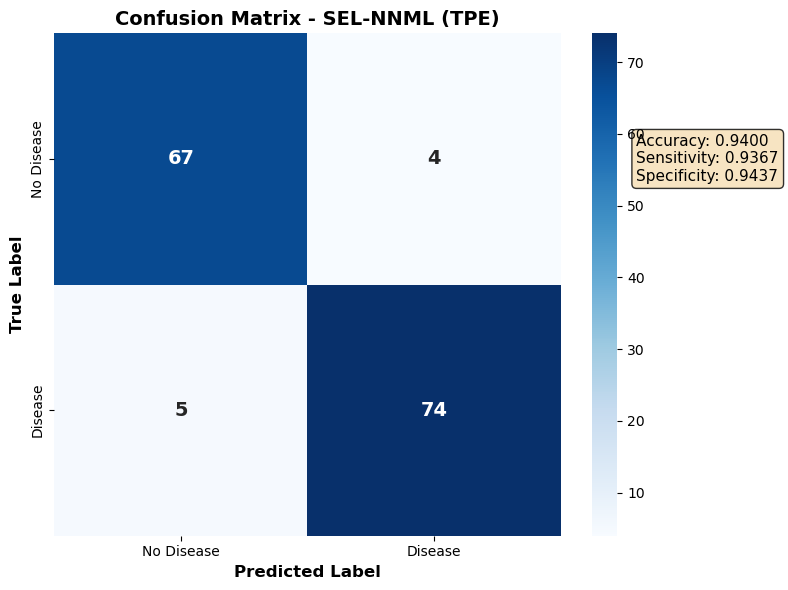


CONFUSION MATRIX METRICS - SEL-NNML (TPE)
True Negatives (TN):  67
False Positives (FP): 4
False Negatives (FN): 5
True Positives (TP):  74
------------------------------------------------------------
Accuracy:    0.9400
Sensitivity: 0.9367 (Recall/TPR)
Specificity: 0.9437 (TNR)


In [16]:
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred_tpe = tpe_model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_tpe)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            annot_kws={'size': 14, 'weight': 'bold'})

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - SEL-NNML (TPE)', fontsize=14, fontweight='bold')

# Add accuracy metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)  # Recall / True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate

metrics_text = f'Accuracy: {accuracy:.4f}\nSensitivity: {sensitivity:.4f}\nSpecificity: {specificity:.4f}'
ax.text(2.3, 0.5, metrics_text, fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        verticalalignment='center')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n" + "="*60)
print("CONFUSION MATRIX METRICS - SEL-NNML (TPE)")
print("="*60)
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")
print("-"*60)
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f} (Recall/TPR)")
print(f"Specificity: {specificity:.4f} (TNR)")
print("="*60)

## 3.3 Feature Importance - SEL-NNML TPE

In [17]:
# Load feature importance data for TPE sampler
fi_path = '../artifacts/ds1/models/tpe/sel-nnml_feature_importance.csv'

if os.path.exists(fi_path):
    fi_df = pd.read_csv(fi_path)
    print(f"✓ Loaded TPE feature importance: {fi_df.shape}")
    display(fi_df.head(10))
else:
    print(f"⚠ Feature importance file not found: {fi_path}")
    fi_df = None

✓ Loaded TPE feature importance: (18, 3)


,Feature,Importance Mean,Importance Std
0,ST_Slope_Up,0.074889,0.015746
1,ST_Slope_Flat,0.049778,0.009227
2,ChestPainType_ASY,0.041333,0.012579
3,Cholesterol,0.036667,0.009389
4,Sex,0.034667,0.010527
5,ExerciseAngina,0.030222,0.013415
6,MaxHR,0.026889,0.009347
7,Age,0.021111,0.008791
8,Oldpeak,0.019111,0.013192
9,RestingBP,0.017556,0.009504


## 3.4 Feature Importance - Table View

In [18]:
if fi_df is not None:
    print("\n" + "="*80)
    print("TOP 10 MOST IMPORTANT FEATURES - SEL-NNML (TPE)")
    print("="*80)
    display(fi_df.head(10))
    print("="*80)


TOP 10 MOST IMPORTANT FEATURES - SEL-NNML (TPE)


,Feature,Importance Mean,Importance Std
0,ST_Slope_Up,0.074889,0.015746
1,ST_Slope_Flat,0.049778,0.009227
2,ChestPainType_ASY,0.041333,0.012579
3,Cholesterol,0.036667,0.009389
4,Sex,0.034667,0.010527
5,ExerciseAngina,0.030222,0.013415
6,MaxHR,0.026889,0.009347
7,Age,0.021111,0.008791
8,Oldpeak,0.019111,0.013192
9,RestingBP,0.017556,0.009504


## 3.5 Feature Importance - Horizontal Bar Chart

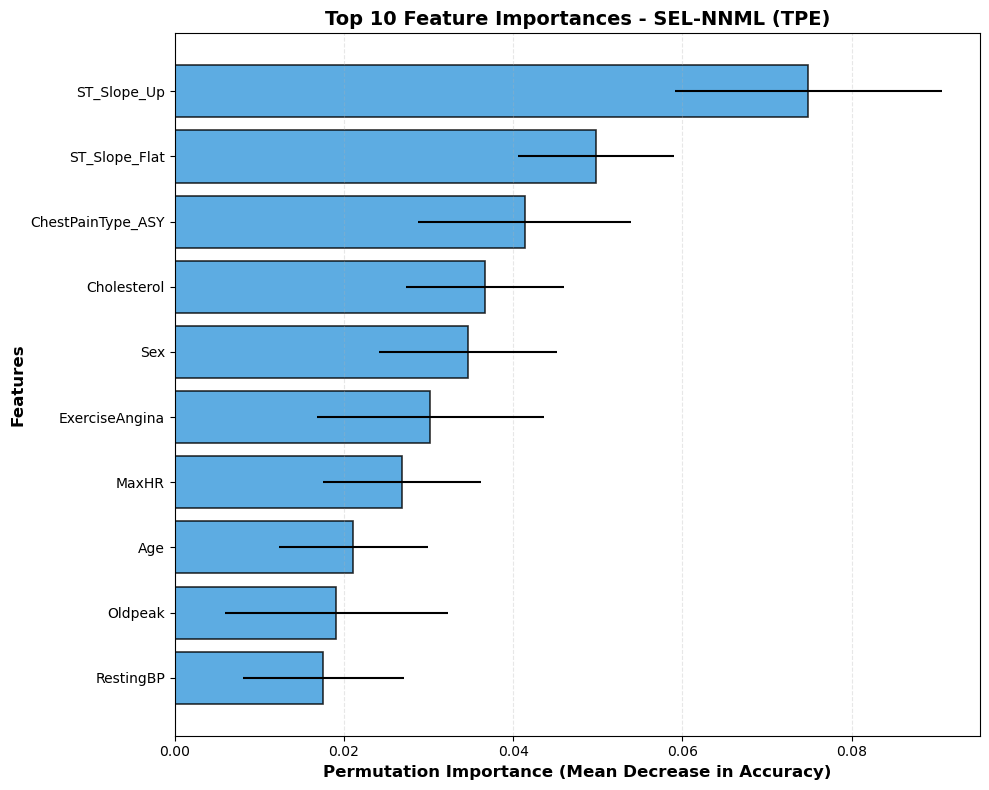

In [19]:
if fi_df is not None:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    top_n = 10
    top_features = fi_df.head(top_n)
    
    y_pos = np.arange(len(top_features))
    bars = ax.barh(y_pos, top_features['Importance Mean'].values, 
                   xerr=top_features['Importance Std'].values,
                   align='center', alpha=0.8, color='#3498db',
                   edgecolor='black', linewidth=1.2)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_features['Feature'].values)
    ax.invert_yaxis()
    ax.set_xlabel('Permutation Importance (Mean Decrease in Accuracy)', 
                  fontsize=12, fontweight='bold')
    ax.set_ylabel('Features', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {top_n} Feature Importances - SEL-NNML (TPE)', 
                 fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

## 3.6 Feature Importance - Cumulative Analysis

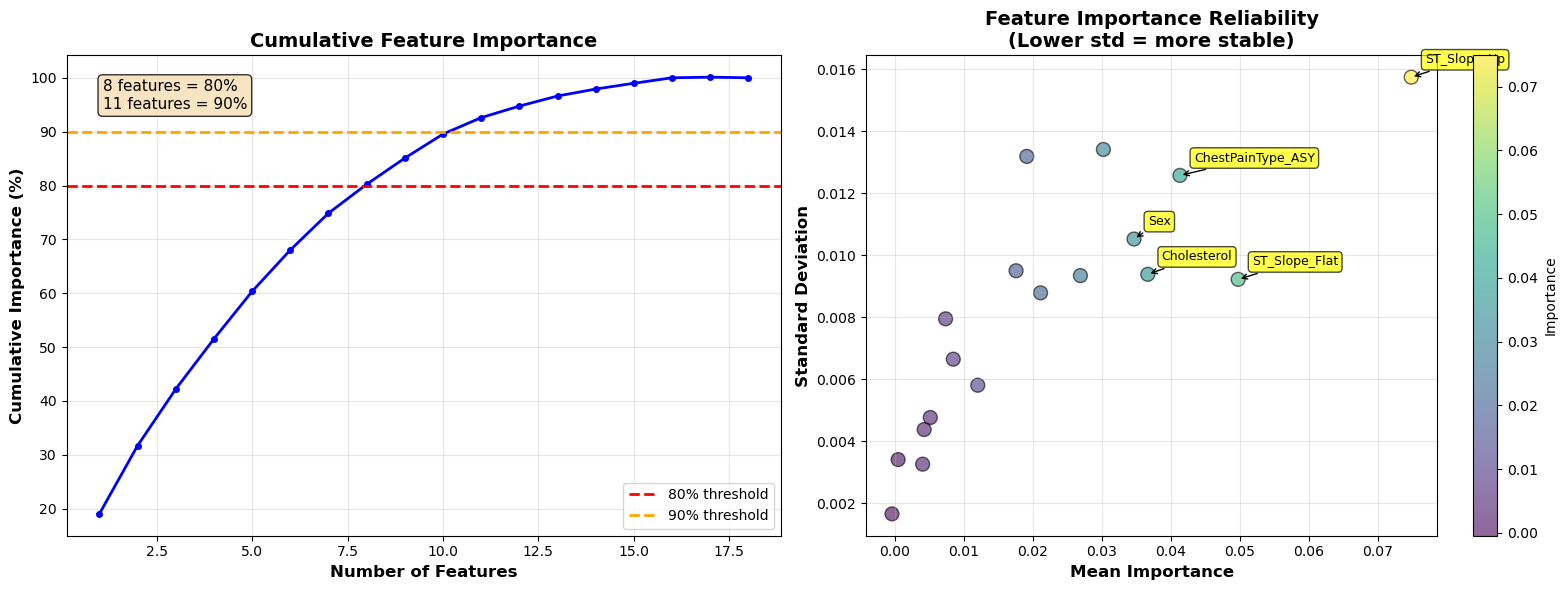

In [20]:
if fi_df is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Cumulative importance
    sorted_importance = fi_df.sort_values('Importance Mean', ascending=False)
    cumulative_importance = np.cumsum(sorted_importance['Importance Mean'].values)
    cumulative_importance_normalized = cumulative_importance / cumulative_importance[-1] * 100
    
    ax1.plot(range(1, len(cumulative_importance_normalized) + 1), cumulative_importance_normalized, 
             'b-', linewidth=2, marker='o', markersize=4, 
             markevery=max(1, len(cumulative_importance_normalized)//20))
    ax1.axhline(y=80, color='r', linestyle='--', linewidth=2, label='80% threshold')
    ax1.axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% threshold')
    ax1.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    n_features_80 = np.argmax(cumulative_importance_normalized >= 80) + 1
    n_features_90 = np.argmax(cumulative_importance_normalized >= 90) + 1
    ax1.text(0.05, 0.95, f'{n_features_80} features = 80%\n{n_features_90} features = 90%',
             transform=ax1.transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Right: Reliability plot
    ax2.scatter(fi_df['Importance Mean'], fi_df['Importance Std'],
                alpha=0.6, s=100, c=fi_df['Importance Mean'], cmap='viridis', edgecolors='black')
    
    top_5 = fi_df.head(5)
    for idx, row in top_5.iterrows():
        ax2.annotate(row['Feature'], 
                    xy=(row['Importance Mean'], row['Importance Std']),
                    xytext=(10, 10), textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    ax2.set_xlabel('Mean Importance', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Standard Deviation', fontsize=12, fontweight='bold')
    ax2.set_title('Feature Importance Reliability\n(Lower std = more stable)', 
                  fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(ax2.collections[0], ax=ax2, label='Importance')
    
    plt.tight_layout()
    plt.show()

## 3.8 Save Part 3 Visualizations

In [21]:
# Save confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
y_pred_tpe = tpe_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_tpe)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - SEL-NNML (TPE)', fontsize=14, fontweight='bold')
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
metrics_text = f'Accuracy: {accuracy:.4f}\nSensitivity: {sensitivity:.4f}\nSpecificity: {specificity:.4f}'
ax.text(2.3, 0.5, metrics_text, fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        verticalalignment='center')
plt.tight_layout()
cm_path = os.path.join(viz_dir, 'part3_confusion_matrix.png')
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f'✓ Confusion matrix saved to: {cm_path}')
plt.close()

# Save feature importance bar chart
if fi_df is not None:
    fig, ax = plt.subplots(figsize=(10, 8))
    top_n = 10
    top_features = fi_df.head(top_n)
    y_pos = np.arange(len(top_features))
    bars = ax.barh(y_pos, top_features['Importance Mean'].values, 
                   xerr=top_features['Importance Std'].values,
                   align='center', alpha=0.8, color='#3498db',
                   edgecolor='black', linewidth=1.2)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_features['Feature'].values)
    ax.invert_yaxis()
    ax.set_xlabel('Permutation Importance (Mean Decrease in Accuracy)', 
                  fontsize=12, fontweight='bold')
    ax.set_ylabel('Features', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {top_n} Feature Importances - SEL-NNML (TPE)', 
                 fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    fi_bar_path = os.path.join(viz_dir, 'part3_feature_importance_bar.png')
    plt.savefig(fi_bar_path, dpi=300, bbox_inches='tight')
    print(f'✓ Feature importance bar chart saved to: {fi_bar_path}')
    plt.close()
    
    # Save cumulative analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    sorted_importance = fi_df.sort_values('Importance Mean', ascending=False)
    cumulative_importance = np.cumsum(sorted_importance['Importance Mean'].values)
    cumulative_importance_normalized = cumulative_importance / cumulative_importance[-1] * 100
    ax1.plot(range(1, len(cumulative_importance_normalized) + 1), cumulative_importance_normalized, 
             'b-', linewidth=2, marker='o', markersize=4, 
             markevery=max(1, len(cumulative_importance_normalized)//20))
    ax1.axhline(y=80, color='r', linestyle='--', linewidth=2, label='80% threshold')
    ax1.axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% threshold')
    ax1.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    n_features_80 = np.argmax(cumulative_importance_normalized >= 80) + 1
    n_features_90 = np.argmax(cumulative_importance_normalized >= 90) + 1
    ax1.text(0.05, 0.95, f'{n_features_80} features = 80%\n{n_features_90} features = 90%',
             transform=ax1.transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    ax2.scatter(fi_df['Importance Mean'], fi_df['Importance Std'],
                alpha=0.6, s=100, c=fi_df['Importance Mean'], cmap='viridis', edgecolors='black')
    top_5 = fi_df.head(5)
    for idx, row in top_5.iterrows():
        ax2.annotate(row['Feature'], 
                    xy=(row['Importance Mean'], row['Importance Std']),
                    xytext=(10, 10), textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    ax2.set_xlabel('Mean Importance', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Standard Deviation', fontsize=12, fontweight='bold')
    ax2.set_title('Feature Importance Reliability\n(Lower std = more stable)', 
                  fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(ax2.collections[0], ax=ax2, label='Importance')
    plt.tight_layout()
    fi_cum_path = os.path.join(viz_dir, 'part3_feature_importance_cumulative.png')
    plt.savefig(fi_cum_path, dpi=300, bbox_inches='tight')
    print(f'✓ Feature importance cumulative analysis saved to: {fi_cum_path}')
    plt.close()
    
    print(f'\n✅ Part 3 visualizations saved to {viz_dir}')
else:
    print("⚠ Skipping Part 3 saves - feature importance data not loaded")

✓ Confusion matrix saved to: ../artifacts/ds1/visualizations\part3_confusion_matrix.png
✓ Feature importance bar chart saved to: ../artifacts/ds1/visualizations\part3_feature_importance_bar.png
✓ Feature importance cumulative analysis saved to: ../artifacts/ds1/visualizations\part3_feature_importance_cumulative.png

✅ Part 3 visualizations saved to ../artifacts/ds1/visualizations


---
# **Summary**

All visualizations have been organized into three main parts:

**Part 1:** All models comparison across different samplers
- Performance metrics (tables + visualizations)
- Heatmaps showing model × sampler combinations
- ROC curves for all models

**Part 2:** HPO methods comparison for SEL-NNML
- Performance comparison across HPO methods (tables + visualizations)
- Optimization convergence plots
- Computational cost analysis (timing tables + visualizations)
- ROC curves comparing HPO methods

**Part 3:** Detailed SEL-NNML analysis (TPE only)
- Confusion matrix (requires test data)
- Feature importance (tables + multiple visualizations)
- Ablation study (placeholder for future implementation)

All plots are saved to: `../artifacts/ds1/visualizations/`